In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

In [2]:
# hyperparameters
N = 10 # number of bits
k = 2 # base of the bits
tau = 1.
SEED = 1
CUDA = torch.cuda.is_available()
BSIZE = 100

SAVE_FOLDER = 'checkpoint_conceptual_loss'
import os
os.system('mkdir -p {}'.format(SAVE_FOLDER))

0

In [3]:
torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)

In [4]:
# Transform to binary MNIST
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x>0.5,
        lambda x: x.float(),
    ])

# dataset loading
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=True, download=True, transform=data_transforms), batch_size=BSIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=False, download=True, transform=data_transforms), batch_size=BSIZE, shuffle=True)

In [5]:
# TODO: UPDATE TO BINARY GUMBEL (REFER TO L0-REG PAPER)
# gumbel-softmax
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    v = Variable(torch.log(-torch.log(U + eps) + eps))
    if CUDA:
        v = v.cuda()
    return -v

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature, hard=True):
    """
    Outputs the hard version, but use soft version's gradients.
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    if hard:
        shape = y.size()
        _, ind = y.max(dim=-1)
        y_hard = torch.zeros_like(y).view(-1, shape[-1])
        y_hard.scatter_(1, ind.view(-1, 1), 1)
        y_hard = y_hard.view(*shape)
        return (y_hard - y).detach() + y
    else:
        return y

In [6]:
gumbel_softmax(Variable(torch.Tensor([[1,2],[1,4]])).cuda(), temperature=0.1, hard=False)

Variable containing:
 9.9478e-01  5.2197e-03
 1.8930e-18  1.0000e+00
[torch.cuda.FloatTensor of size 2x2 (GPU 0)]

In [7]:
HIDDEN_SIZE = 128

def prob(outputs):
    # approx probs of gumble softmax, TODO what is the actual prob?
    outputs = [F.softmax(out, dim=-1) for out in outputs]
    return torch.cat(outputs, dim=1).view(-1, N, k)

def sample(l):
    # return bits
    gs = gumbel_softmax(l, tau)
    return gs.narrow(1,0,1)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, HIDDEN_SIZE),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.net(x)
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)
    
class Tunnel(nn.Module):
    def __init__(self):
        super(Tunnel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1+HIDDEN_SIZE, HIDDEN_SIZE), # input: bit + prev hidden
            nn.ReLU(),
# MAKE SIMPLER
#             nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
#             nn.ReLU()
        )
        
    def forward(self, x):
        return self.net(x)
    
class Output(nn.Module):
    def __init__(self):
        super(Output, self).__init__()
        self.net = nn.Sequential(
# MAKE SIMPLER
#             nn.Linear(HIDDEN_SIZE, 64),
#             nn.ReLU(),
#             nn.Linear(64, 2),
#             nn.ReLU()
            nn.Linear(HIDDEN_SIZE, 2),
            nn.ReLU()
        )
        
    def forward(self, x):
        h = self.net(x)
        return h.view(-1,2)
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
        # TODO try recurrent
        
        # Option 1: Different tunnels. (Works ok)
#         self.ou = nn.ModuleList([Output() for _ in range(N)])
#         self.te = nn.ModuleList([Tunnel() for _ in range(N)]) # encoder tunnels
#         self.td = nn.ModuleList([Tunnel() for _ in range(N)]) # decoder tunnels
        
        # Option 2: Same tunnel for all of top and all of bottom (Better; faster training)
        _te = Tunnel()
        _td = Tunnel()
        self.ou = nn.ModuleList([Output() for _ in range(N)])
        self.te = nn.ModuleList([_te for _ in range(N)]) # encoder tunnels
        self.td = nn.ModuleList([_td for _ in range(N)]) # decoder tunnels

#         # Option 3: All shared. One big shared unit. (Doesn't work)
#         _ou = Output()
#         _te = Tunnel()
#         _td = Tunnel()
#         self.ou = nn.ModuleList([_ou for _ in range(N)])
#         self.te = nn.ModuleList([_te for _ in range(N)]) # encoder tunnels
#         self.td = nn.ModuleList([_td for _ in range(N)]) # decoder tunnels
        
    def forward(self, x):
        top_hiddens = [self.encoder(x)] # first is features from the image
        btm_hiddens = [torch.zeros_like(top_hiddens[-1])] # first is dummy input into decoder
        outputs = []
        
        for i in range(N):
            out = self.ou[i](top_hiddens[-1])
            outputs.append(out)
            bit = sample(out)

            top_inp = torch.cat([bit, top_hiddens[-1]], -1)
            top_hiddens.append(self.te[i](top_inp))

            btm_inp = torch.cat([bit, btm_hiddens[-1]], -1)
            btm_hiddens.append(self.td[i](btm_inp))
        
        x_hat = self.decoder(btm_hiddens[-1])
        
        return x_hat, outputs, top_hiddens, btm_hiddens
    
    def bits_to_recon(self, bits):
        # NOTE: this is more of a debugging function. TODO Make sure gradients don't get stored.
        init_zeros = Variable(torch.zeros(1, HIDDEN_SIZE))
        if self.is_cuda():
            init_zeros = init_zeros.cuda()
        btm_hiddens = [init_zeros] # first is dummy input into decoder
        
        for i in range(N):
            bit = bits[:,i:i+1]
            btm_inp = torch.cat([bit, btm_hiddens[-1]], -1)
            btm_hiddens.append(self.td[i](btm_inp))
            
        x_hat = self.decoder(btm_hiddens[-1])
        
        return x_hat
    
    def save(self):
        torch.save(self.state_dict(), '{}/net'.format(SAVE_FOLDER))
        
    def is_cuda(self):
        return next(self.parameters()).is_cuda
    
# net = Net()
# _, (data, _) = next(enumerate(train_loader))
# data = Variable(data.view(-1, 784))
# data.shape
# net(data)

In [8]:
# TODO
# objective
def recon_loss(recon_x, x):
    return F.binary_cross_entropy(recon_x, x, size_average=False)#/BSIZE
    
def kld_loss(q):
    # Assuming independent latent
    return torch.sum(q*(torch.log(q+1e-20)-np.log(1/k)))
#     # Assuming dependent latent
#     KLD = get_dependent_prior_loss(x)

def concept_loss(top_hiddens, bottom_hiddens):
    diffs = 0
    for i in range(1, len(top_hiddens)):
        diff = (top_hiddens[i] - top_hiddens[0]) - bottom_hiddens[i-1]
        diff = diff.pow(2).mean()
        diffs += diff
    return diffs
        
net = Net()
_, (data, _) = next(enumerate(train_loader))
data = Variable(data.view(-1, 784))
if CUDA:
    net.cuda()
    data = data.cuda()
data.shape
x_hat, outputs, top_hiddens, btm_hiddens = net(data)
concept_loss(top_hiddens, btm_hiddens)
recon_loss(x_hat, data)
q = prob(outputs)
kld_loss(q)

Variable containing:
 0.1733
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [16]:
from itertools import product

def debug(start=0):
    nn = min(N, 5) # else it's too many to plot
    f, axes = plt.subplots(1, 2**nn, sharey=True, figsize=(25,1))
    kk = 0
    ss = 0

    def make_variable(value):
        t = torch.Tensor([value]).type(torch.FloatTensor)
        v = Variable(t)
        if CUDA:
            v = v.cuda()
        return v

    for path in product(range(2), repeat=N):
        if ss < start:
            ss += 1
        else:
            w = net.bits_to_recon(make_variable(path))
            ax = axes[kk]
            ax.set_title(path)
            ax.imshow(w.view(28,28).cpu().data.numpy())
            kk += 1
            if kk >= 2**nn:
                break
        
    plt.show()

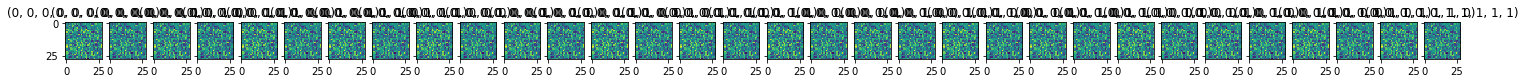

In [10]:
net = Net()
if CUDA:
    net.cuda()
    
optimizer = optim.Adam(net.parameters(), lr=1e-4)
best_loss_sofar = 9999

debug() # test it out

In [11]:
def train(epoch):
    global best_loss_sofar
    train_bce_loss = 0
    train_kld_loss = 0
    train_con_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if CUDA:
            data = data.cuda()
        x = data.view(-1,784)
        optimizer.zero_grad()
        
        recon_x, outputs, top_hiddens, btm_hiddens = net(x)
        
        q = prob(outputs)
        BCE = recon_loss(recon_x, x)
        KLD = kld_loss(q) 
        CON = concept_loss(top_hiddens, btm_hiddens)
        loss = BCE + KLD + CON
        loss.backward()
        optimizer.step()
        
        train_bce_loss += BCE.data[0]
        train_kld_loss += KLD.data[0]
        train_con_loss += CON.data[0]
        
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBCE loss: {:.6f}\tKLD loss: {:.6f}\tCON loss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                BCE.data[0] / len(data),
                KLD.data[0] / len(data),
                CON.data[0] / len(data)))
            
    avg_bce_loss = train_bce_loss / len(train_loader.dataset)
    avg_kld_loss = train_kld_loss / len(train_loader.dataset)
    avg_con_loss = train_con_loss / len(train_loader.dataset)
    avg_loss = avg_bce_loss + avg_kld_loss + avg_con_loss
    print('====> Epoch: {} Average BCE loss: {:.4f}, Average KLD loss: {:.4f}, Average CON loss: {:.4f}, Total: {:.4f}'.format(
          epoch+1, avg_bce_loss, avg_kld_loss, avg_con_loss, avg_loss))
    
    if avg_loss < best_loss_sofar:
        print("Loss {} is better than previous best {}, saving model".format(avg_loss, best_loss_sofar))
        net.save()
        best_loss_sofar = avg_loss
        debug()

Train Epoch: 1 [0/60000 (0%)]	BCE loss: 542.777187	KLD loss: 0.003706	CON loss: 0.000662
Train Epoch: 1 [20000/60000 (33%)]	BCE loss: 200.489375	KLD loss: 0.077790	CON loss: 0.025720
Train Epoch: 1 [40000/60000 (67%)]	BCE loss: 211.563828	KLD loss: 0.763037	CON loss: 0.044369
====> Epoch: 1 Average BCE loss: 248.7352, Average KLD loss: 0.4633, Average CON loss: 0.0326, Total: 249.2311
Loss 249.2310795361301 is better than previous best 9999, saving model


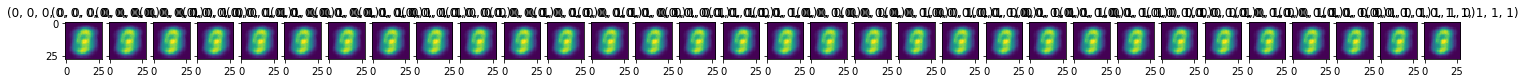

CPU times: user 16.1 s, sys: 1.52 s, total: 17.6 s
Wall time: 15.9 s


In [12]:
%%time
train(0)

Train Epoch: 2 [0/60000 (0%)]	BCE loss: 199.219492	KLD loss: 1.153500	CON loss: 0.046849
Train Epoch: 2 [20000/60000 (33%)]	BCE loss: 201.580820	KLD loss: 1.412247	CON loss: 0.054961
Train Epoch: 2 [40000/60000 (67%)]	BCE loss: 199.595898	KLD loss: 1.376618	CON loss: 0.044194
====> Epoch: 2 Average BCE loss: 200.5307, Average KLD loss: 1.5003, Average CON loss: 0.0504, Total: 202.0814
Loss 202.0814331170281 is better than previous best 249.2310795361301, saving model


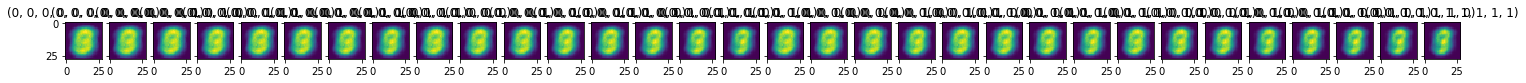

Train Epoch: 3 [0/60000 (0%)]	BCE loss: 195.188945	KLD loss: 1.581691	CON loss: 0.047669
Train Epoch: 3 [20000/60000 (33%)]	BCE loss: 200.321836	KLD loss: 1.882217	CON loss: 0.063972
Train Epoch: 3 [40000/60000 (67%)]	BCE loss: 188.779824	KLD loss: 2.253231	CON loss: 0.055158
====> Epoch: 3 Average BCE loss: 193.6109, Average KLD loss: 1.9867, Average CON loss: 0.0563, Total: 195.6539
Loss 195.65386870834828 is better than previous best 202.0814331170281, saving model


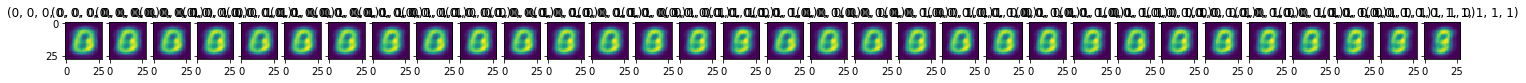

Train Epoch: 4 [0/60000 (0%)]	BCE loss: 196.623457	KLD loss: 2.005812	CON loss: 0.048042
Train Epoch: 4 [20000/60000 (33%)]	BCE loss: 196.864492	KLD loss: 2.075327	CON loss: 0.055534
Train Epoch: 4 [40000/60000 (67%)]	BCE loss: 187.788906	KLD loss: 2.455511	CON loss: 0.067700
====> Epoch: 4 Average BCE loss: 190.6389, Average KLD loss: 2.2569, Average CON loss: 0.0555, Total: 192.9513
Loss 192.95130810213882 is better than previous best 195.65386870834828, saving model


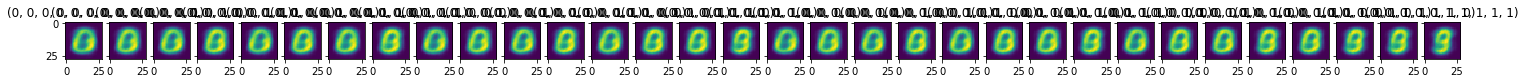

Train Epoch: 5 [0/60000 (0%)]	BCE loss: 194.705566	KLD loss: 2.357604	CON loss: 0.060136
Train Epoch: 5 [20000/60000 (33%)]	BCE loss: 186.445137	KLD loss: 2.200695	CON loss: 0.051281
Train Epoch: 5 [40000/60000 (67%)]	BCE loss: 185.833359	KLD loss: 2.242742	CON loss: 0.049097
====> Epoch: 5 Average BCE loss: 188.6577, Average KLD loss: 2.3874, Average CON loss: 0.0544, Total: 191.0995
Loss 191.09950085554917 is better than previous best 192.95130810213882, saving model


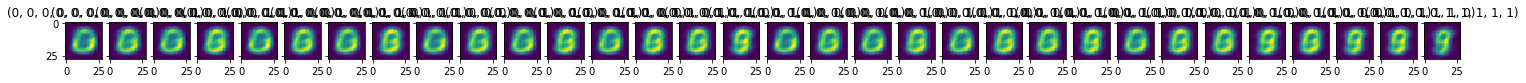

Train Epoch: 6 [0/60000 (0%)]	BCE loss: 188.532695	KLD loss: 2.565313	CON loss: 0.050000
Train Epoch: 6 [20000/60000 (33%)]	BCE loss: 184.867656	KLD loss: 2.397291	CON loss: 0.056562
Train Epoch: 6 [40000/60000 (67%)]	BCE loss: 183.304727	KLD loss: 2.227280	CON loss: 0.051213
====> Epoch: 6 Average BCE loss: 186.7000, Average KLD loss: 2.3372, Average CON loss: 0.0555, Total: 189.0927
Loss 189.09272661353347 is better than previous best 191.09950085554917, saving model


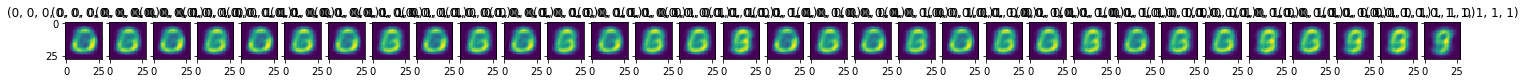

Train Epoch: 7 [0/60000 (0%)]	BCE loss: 190.882617	KLD loss: 2.250280	CON loss: 0.050063
Train Epoch: 7 [20000/60000 (33%)]	BCE loss: 184.832812	KLD loss: 2.307716	CON loss: 0.053972
Train Epoch: 7 [40000/60000 (67%)]	BCE loss: 177.934219	KLD loss: 2.177623	CON loss: 0.051903
====> Epoch: 7 Average BCE loss: 185.6921, Average KLD loss: 2.2988, Average CON loss: 0.0530, Total: 188.0440
Loss 188.04395463709037 is better than previous best 189.09272661353347, saving model


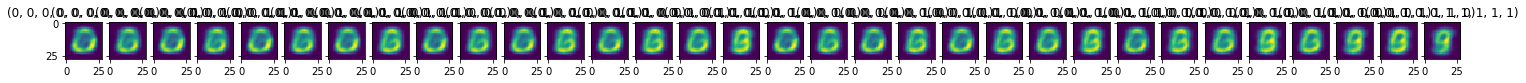

Train Epoch: 8 [0/60000 (0%)]	BCE loss: 186.716641	KLD loss: 2.121535	CON loss: 0.047788
Train Epoch: 8 [20000/60000 (33%)]	BCE loss: 185.367695	KLD loss: 2.325666	CON loss: 0.051424
Train Epoch: 8 [40000/60000 (67%)]	BCE loss: 184.490039	KLD loss: 2.452852	CON loss: 0.058602
====> Epoch: 8 Average BCE loss: 184.6806, Average KLD loss: 2.3520, Average CON loss: 0.0547, Total: 187.0873
Loss 187.08733628753822 is better than previous best 188.04395463709037, saving model


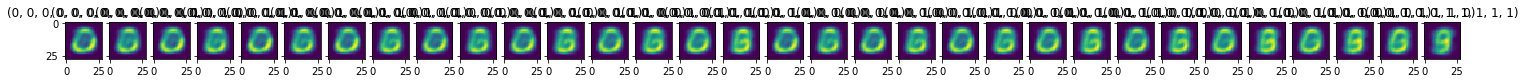

Train Epoch: 9 [0/60000 (0%)]	BCE loss: 190.542617	KLD loss: 2.529380	CON loss: 0.064320
Train Epoch: 9 [20000/60000 (33%)]	BCE loss: 179.813398	KLD loss: 2.539337	CON loss: 0.058436
Train Epoch: 9 [40000/60000 (67%)]	BCE loss: 190.545742	KLD loss: 2.598620	CON loss: 0.074193
====> Epoch: 9 Average BCE loss: 183.1062, Average KLD loss: 2.5048, Average CON loss: 0.0649, Total: 185.6759
Loss 185.67592059679822 is better than previous best 187.08733628753822, saving model


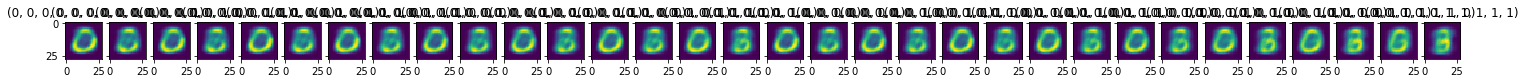

Train Epoch: 10 [0/60000 (0%)]	BCE loss: 181.515820	KLD loss: 2.587053	CON loss: 0.076576
Train Epoch: 10 [20000/60000 (33%)]	BCE loss: 182.718652	KLD loss: 2.510854	CON loss: 0.085292
Train Epoch: 10 [40000/60000 (67%)]	BCE loss: 181.045117	KLD loss: 2.813182	CON loss: 0.088020
====> Epoch: 10 Average BCE loss: 179.9445, Average KLD loss: 2.7360, Average CON loss: 0.0798, Total: 182.7603
Loss 182.76026596856119 is better than previous best 185.67592059679822, saving model


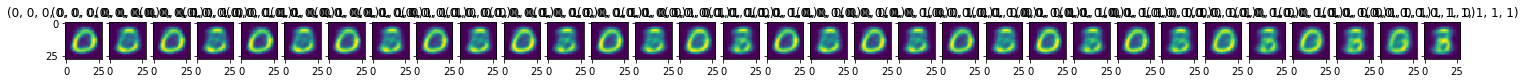

In [13]:
for i in range(1, 10):
    train(i)

Train Epoch: 12 [0/60000 (0%)]	BCE loss: 184.509258	KLD loss: 2.737902	CON loss: 0.074968
Train Epoch: 12 [20000/60000 (33%)]	BCE loss: 189.160156	KLD loss: 2.965201	CON loss: 0.095278
Train Epoch: 12 [40000/60000 (67%)]	BCE loss: 180.228574	KLD loss: 2.914905	CON loss: 0.092748
====> Epoch: 12 Average BCE loss: 177.7299, Average KLD loss: 2.8857, Average CON loss: 0.0870, Total: 180.7026
Loss 180.70255802450976 is better than previous best 182.76026596856119, saving model


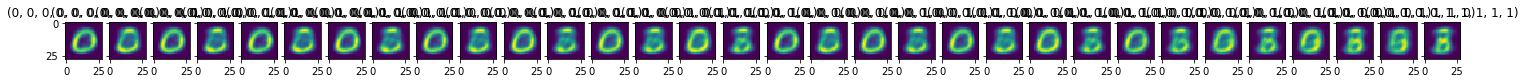

Train Epoch: 13 [0/60000 (0%)]	BCE loss: 179.932461	KLD loss: 2.991552	CON loss: 0.094700
Train Epoch: 13 [20000/60000 (33%)]	BCE loss: 170.324688	KLD loss: 2.997896	CON loss: 0.082483
Train Epoch: 13 [40000/60000 (67%)]	BCE loss: 175.481719	KLD loss: 3.121391	CON loss: 0.097954
====> Epoch: 13 Average BCE loss: 176.2851, Average KLD loss: 2.9937, Average CON loss: 0.0903, Total: 179.3692
Loss 179.36917141052882 is better than previous best 180.70255802450976, saving model


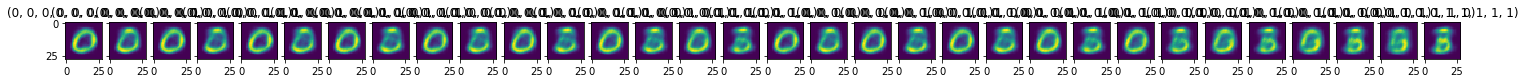

Train Epoch: 14 [0/60000 (0%)]	BCE loss: 181.589922	KLD loss: 3.003960	CON loss: 0.081990
Train Epoch: 14 [20000/60000 (33%)]	BCE loss: 171.962559	KLD loss: 2.840714	CON loss: 0.080517
Train Epoch: 14 [40000/60000 (67%)]	BCE loss: 176.781914	KLD loss: 3.083047	CON loss: 0.092684
====> Epoch: 14 Average BCE loss: 175.0934, Average KLD loss: 3.0726, Average CON loss: 0.0921, Total: 178.2581
Loss 178.25811920533974 is better than previous best 179.36917141052882, saving model


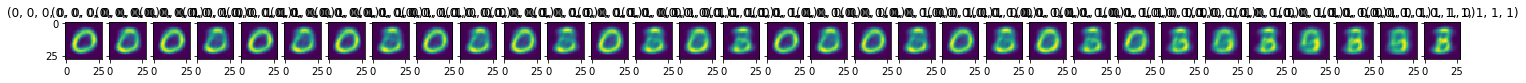

Train Epoch: 15 [0/60000 (0%)]	BCE loss: 165.215039	KLD loss: 3.121402	CON loss: 0.091857
Train Epoch: 15 [20000/60000 (33%)]	BCE loss: 178.771094	KLD loss: 3.091537	CON loss: 0.095829
Train Epoch: 15 [40000/60000 (67%)]	BCE loss: 163.512598	KLD loss: 3.218235	CON loss: 0.093111
====> Epoch: 15 Average BCE loss: 174.2828, Average KLD loss: 3.1758, Average CON loss: 0.0956, Total: 177.5542
Loss 177.5542206376791 is better than previous best 178.25811920533974, saving model


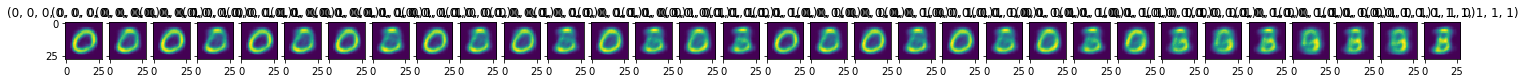

Train Epoch: 16 [0/60000 (0%)]	BCE loss: 171.408340	KLD loss: 3.398538	CON loss: 0.104313
Train Epoch: 16 [20000/60000 (33%)]	BCE loss: 176.255605	KLD loss: 3.153033	CON loss: 0.097711
Train Epoch: 16 [40000/60000 (67%)]	BCE loss: 176.999434	KLD loss: 3.313740	CON loss: 0.091926
====> Epoch: 16 Average BCE loss: 173.6299, Average KLD loss: 3.3378, Average CON loss: 0.0968, Total: 177.0645
Loss 177.06451184996763 is better than previous best 177.5542206376791, saving model


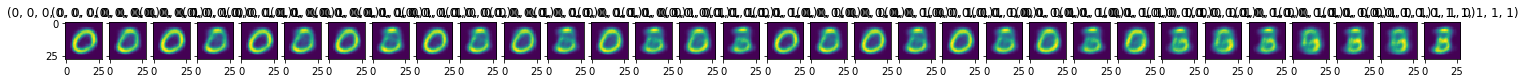

Train Epoch: 17 [0/60000 (0%)]	BCE loss: 175.258359	KLD loss: 3.492535	CON loss: 0.088865
Train Epoch: 17 [20000/60000 (33%)]	BCE loss: 171.028496	KLD loss: 3.285665	CON loss: 0.090383
Train Epoch: 17 [40000/60000 (67%)]	BCE loss: 169.938750	KLD loss: 3.446473	CON loss: 0.100130
====> Epoch: 17 Average BCE loss: 172.8645, Average KLD loss: 3.4236, Average CON loss: 0.0973, Total: 176.3854
Loss 176.38538834416866 is better than previous best 177.06451184996763, saving model


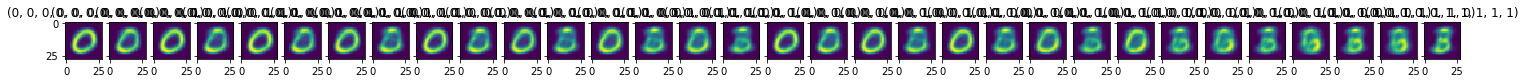

Train Epoch: 18 [0/60000 (0%)]	BCE loss: 185.475000	KLD loss: 3.471158	CON loss: 0.107819
Train Epoch: 18 [20000/60000 (33%)]	BCE loss: 164.582695	KLD loss: 3.434917	CON loss: 0.096585
Train Epoch: 18 [40000/60000 (67%)]	BCE loss: 164.731582	KLD loss: 3.541811	CON loss: 0.097148
====> Epoch: 18 Average BCE loss: 172.2999, Average KLD loss: 3.4698, Average CON loss: 0.0962, Total: 175.8658
Loss 175.86582406677405 is better than previous best 176.38538834416866, saving model


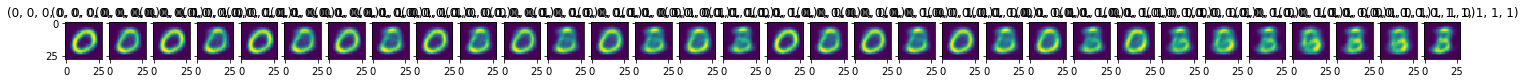

Train Epoch: 19 [0/60000 (0%)]	BCE loss: 168.687715	KLD loss: 3.444230	CON loss: 0.089016
Train Epoch: 19 [20000/60000 (33%)]	BCE loss: 175.883164	KLD loss: 3.460992	CON loss: 0.082450
Train Epoch: 19 [40000/60000 (67%)]	BCE loss: 177.325293	KLD loss: 3.624477	CON loss: 0.086445
====> Epoch: 19 Average BCE loss: 171.8127, Average KLD loss: 3.4749, Average CON loss: 0.0918, Total: 175.3794
Loss 175.37941109167735 is better than previous best 175.86582406677405, saving model


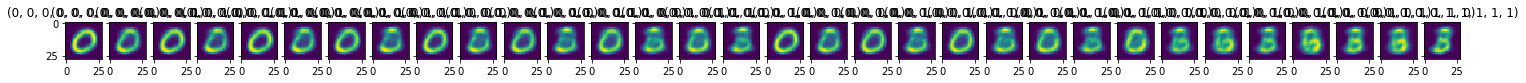

Train Epoch: 20 [0/60000 (0%)]	BCE loss: 169.840547	KLD loss: 3.552941	CON loss: 0.087159
Train Epoch: 20 [20000/60000 (33%)]	BCE loss: 169.485762	KLD loss: 3.439087	CON loss: 0.078227
Train Epoch: 20 [40000/60000 (67%)]	BCE loss: 175.660020	KLD loss: 3.497078	CON loss: 0.093602
====> Epoch: 20 Average BCE loss: 171.1358, Average KLD loss: 3.4870, Average CON loss: 0.0925, Total: 174.7153
Loss 174.71532134551208 is better than previous best 175.37941109167735, saving model


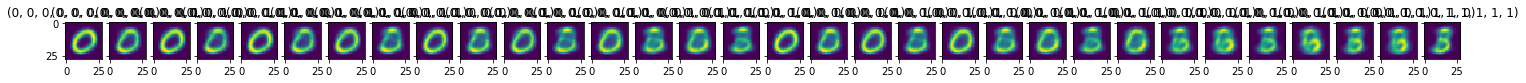

In [22]:
for i in range(11, 20):
    train(i)

Train Epoch: 22 [0/60000 (0%)]	BCE loss: 175.833477	KLD loss: 3.474078	CON loss: 0.101314
Train Epoch: 22 [20000/60000 (33%)]	BCE loss: 163.402656	KLD loss: 3.446735	CON loss: 0.086464
Train Epoch: 22 [40000/60000 (67%)]	BCE loss: 167.584609	KLD loss: 3.670472	CON loss: 0.088308
====> Epoch: 22 Average BCE loss: 170.4995, Average KLD loss: 3.4875, Average CON loss: 0.0893, Total: 174.0762
Loss 174.07622341961064 is better than previous best 174.71532134551208, saving model


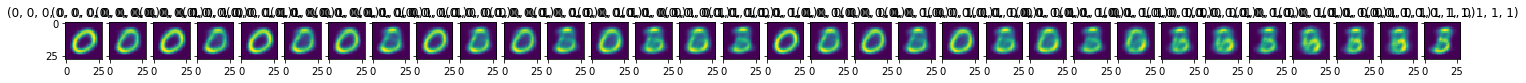

Train Epoch: 23 [0/60000 (0%)]	BCE loss: 169.743906	KLD loss: 3.462535	CON loss: 0.088463
Train Epoch: 23 [20000/60000 (33%)]	BCE loss: 170.001289	KLD loss: 3.456666	CON loss: 0.088011
Train Epoch: 23 [40000/60000 (67%)]	BCE loss: 162.964668	KLD loss: 3.430390	CON loss: 0.080476
====> Epoch: 23 Average BCE loss: 169.9765, Average KLD loss: 3.5128, Average CON loss: 0.0886, Total: 173.5778
Loss 173.5778196486632 is better than previous best 174.07622341961064, saving model


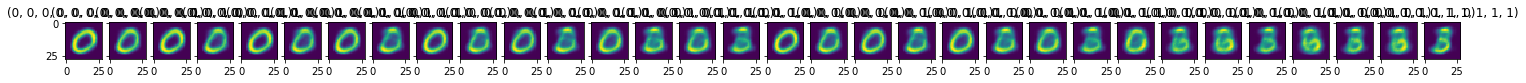

Train Epoch: 24 [0/60000 (0%)]	BCE loss: 169.604492	KLD loss: 3.499294	CON loss: 0.086850
Train Epoch: 24 [20000/60000 (33%)]	BCE loss: 167.411523	KLD loss: 3.464576	CON loss: 0.081699
Train Epoch: 24 [40000/60000 (67%)]	BCE loss: 175.207109	KLD loss: 3.468241	CON loss: 0.085255
====> Epoch: 24 Average BCE loss: 169.5848, Average KLD loss: 3.5195, Average CON loss: 0.0867, Total: 173.1909
Loss 173.19089962320328 is better than previous best 173.5778196486632, saving model


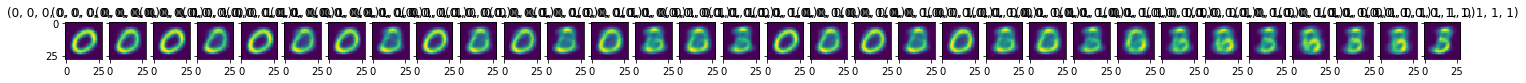

Train Epoch: 25 [0/60000 (0%)]	BCE loss: 174.682559	KLD loss: 3.553753	CON loss: 0.087100
Train Epoch: 25 [20000/60000 (33%)]	BCE loss: 164.688086	KLD loss: 3.533813	CON loss: 0.091418
Train Epoch: 25 [40000/60000 (67%)]	BCE loss: 167.793398	KLD loss: 3.578447	CON loss: 0.080391
====> Epoch: 25 Average BCE loss: 169.0033, Average KLD loss: 3.5452, Average CON loss: 0.0875, Total: 172.6360
Loss 172.63600462591648 is better than previous best 173.19089962320328, saving model


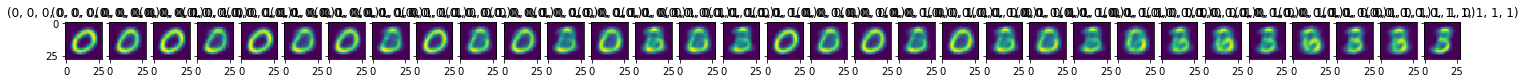

Train Epoch: 26 [0/60000 (0%)]	BCE loss: 169.623574	KLD loss: 3.498326	CON loss: 0.088125
Train Epoch: 26 [20000/60000 (33%)]	BCE loss: 168.994355	KLD loss: 3.586736	CON loss: 0.090673
Train Epoch: 26 [40000/60000 (67%)]	BCE loss: 170.797891	KLD loss: 3.729269	CON loss: 0.084773
====> Epoch: 26 Average BCE loss: 168.6175, Average KLD loss: 3.5626, Average CON loss: 0.0884, Total: 172.2685
Loss 172.2685223017931 is better than previous best 172.63600462591648, saving model


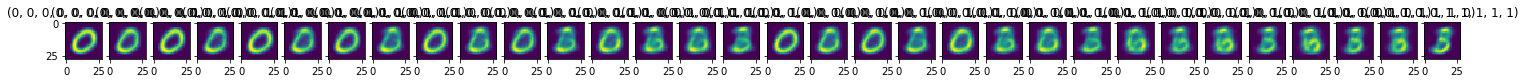

Train Epoch: 27 [0/60000 (0%)]	BCE loss: 164.184258	KLD loss: 3.680814	CON loss: 0.087773
Train Epoch: 27 [20000/60000 (33%)]	BCE loss: 168.415273	KLD loss: 3.585546	CON loss: 0.087036
Train Epoch: 27 [40000/60000 (67%)]	BCE loss: 177.878281	KLD loss: 3.464666	CON loss: 0.080907
====> Epoch: 27 Average BCE loss: 167.9870, Average KLD loss: 3.5783, Average CON loss: 0.0871, Total: 171.6524
Loss 171.6523667691628 is better than previous best 172.2685223017931, saving model


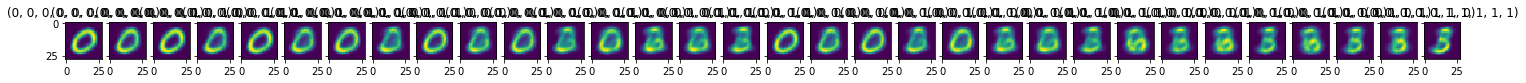

Train Epoch: 28 [0/60000 (0%)]	BCE loss: 175.754883	KLD loss: 3.512880	CON loss: 0.083818
Train Epoch: 28 [20000/60000 (33%)]	BCE loss: 171.337227	KLD loss: 3.517144	CON loss: 0.083999
Train Epoch: 28 [40000/60000 (67%)]	BCE loss: 166.866973	KLD loss: 3.654754	CON loss: 0.086159
====> Epoch: 28 Average BCE loss: 167.5641, Average KLD loss: 3.5886, Average CON loss: 0.0866, Total: 171.2393
Loss 171.23928282105922 is better than previous best 171.6523667691628, saving model


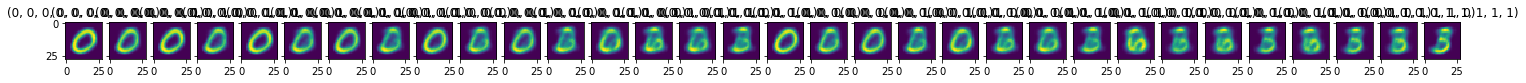

Train Epoch: 29 [0/60000 (0%)]	BCE loss: 164.029277	KLD loss: 3.526853	CON loss: 0.097290
Train Epoch: 29 [20000/60000 (33%)]	BCE loss: 168.910117	KLD loss: 3.555873	CON loss: 0.092603
Train Epoch: 29 [40000/60000 (67%)]	BCE loss: 176.044668	KLD loss: 3.589543	CON loss: 0.086589
====> Epoch: 29 Average BCE loss: 167.2150, Average KLD loss: 3.6099, Average CON loss: 0.0886, Total: 170.9135
Loss 170.9135467787822 is better than previous best 171.23928282105922, saving model


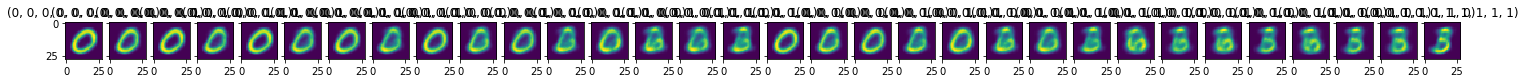

Train Epoch: 30 [0/60000 (0%)]	BCE loss: 166.535469	KLD loss: 3.601406	CON loss: 0.089167
Train Epoch: 30 [20000/60000 (33%)]	BCE loss: 165.571211	KLD loss: 3.560992	CON loss: 0.090519
Train Epoch: 30 [40000/60000 (67%)]	BCE loss: 166.828750	KLD loss: 3.697746	CON loss: 0.091165
====> Epoch: 30 Average BCE loss: 166.5833, Average KLD loss: 3.5820, Average CON loss: 0.0891, Total: 170.2543
Loss 170.2543450946649 is better than previous best 170.9135467787822, saving model


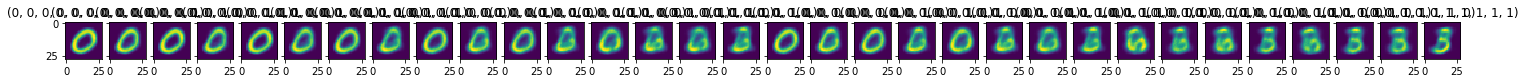

In [24]:
for i in range(21, 30):
    train(i)

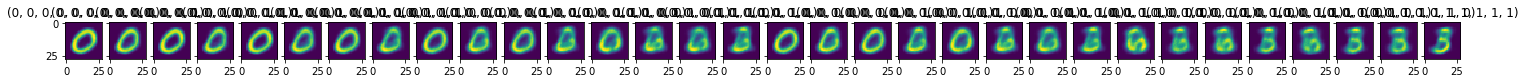

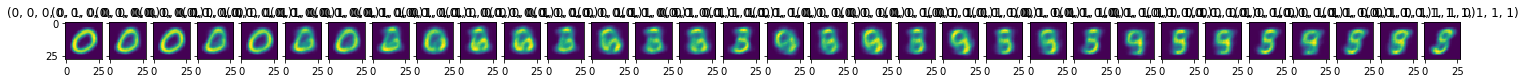

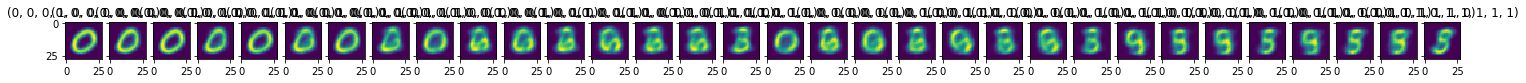

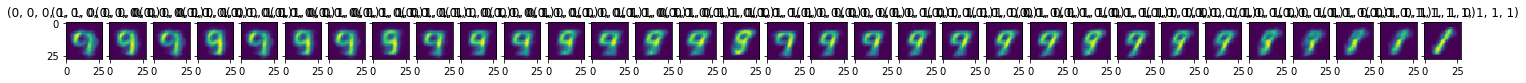

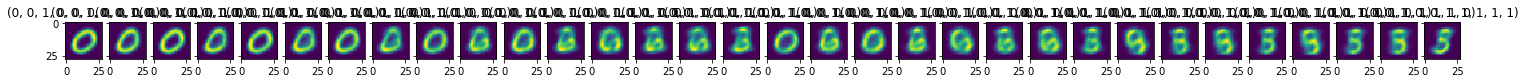

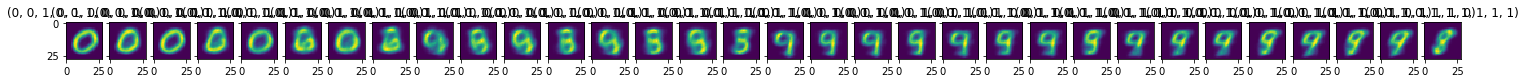

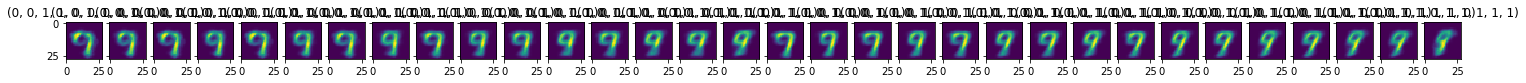

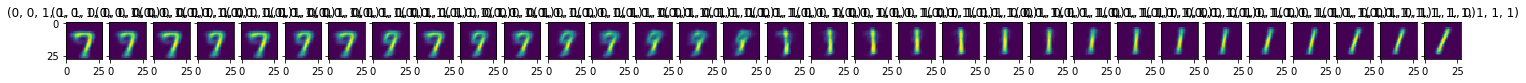

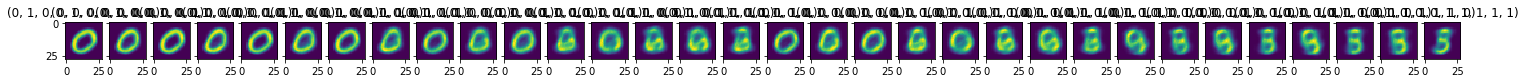

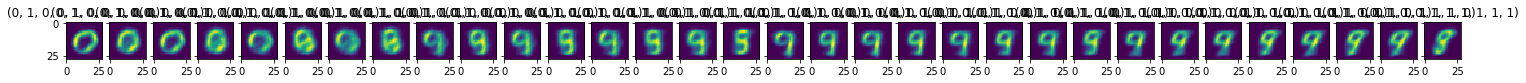

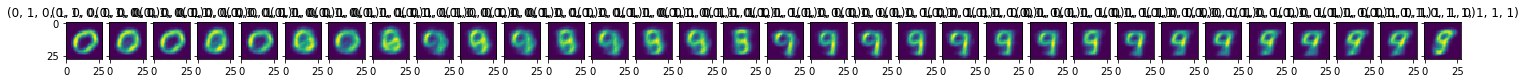

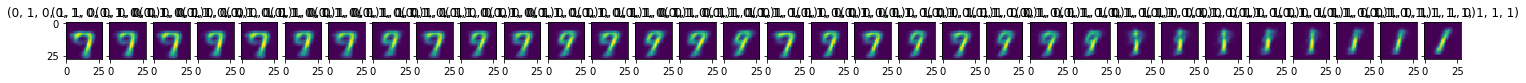

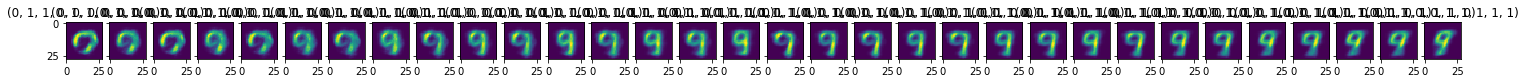

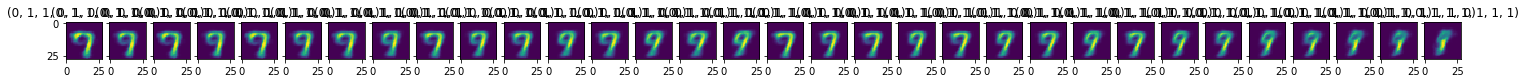

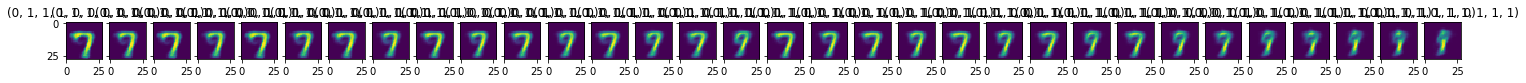

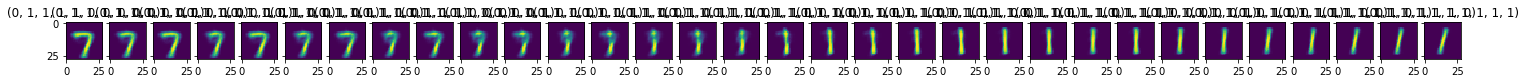

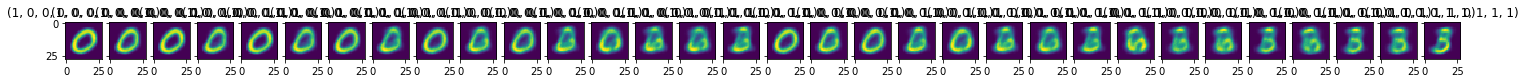

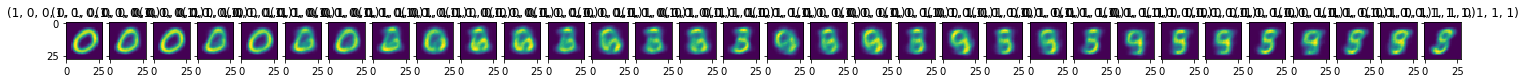

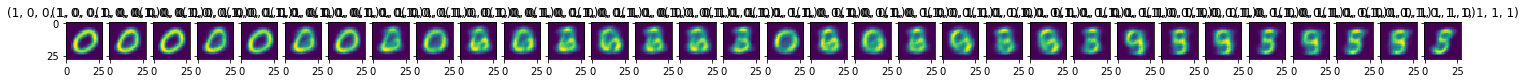

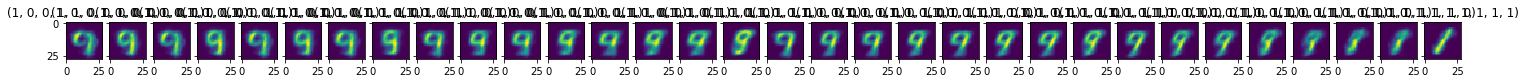

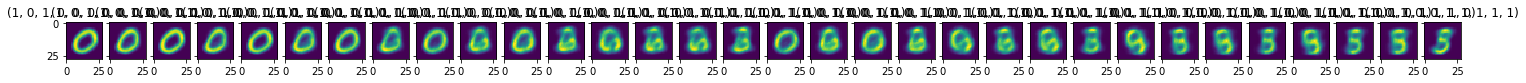

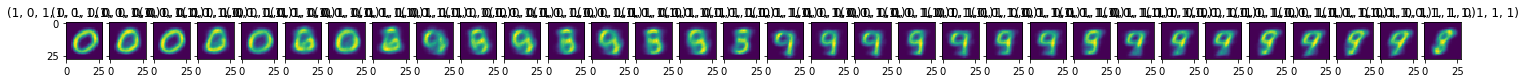

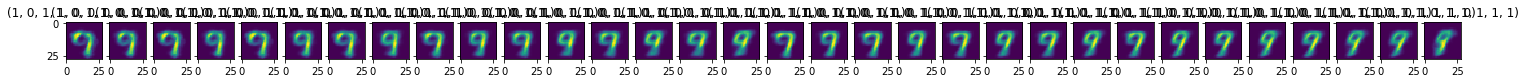

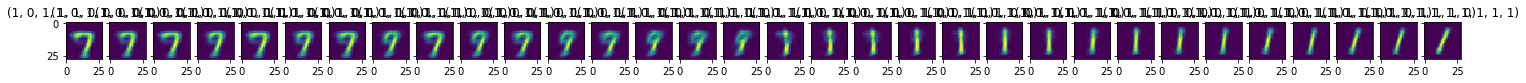

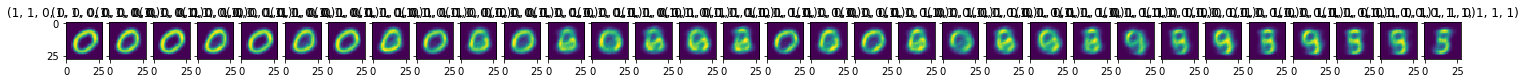

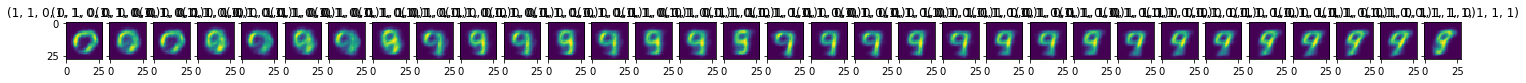

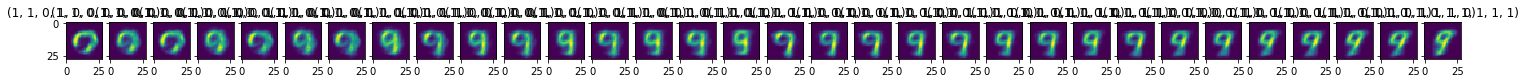

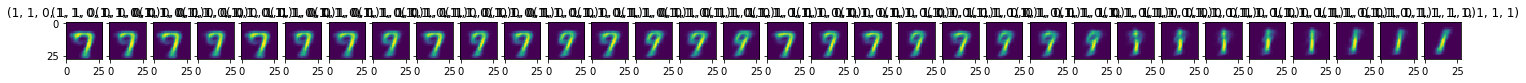

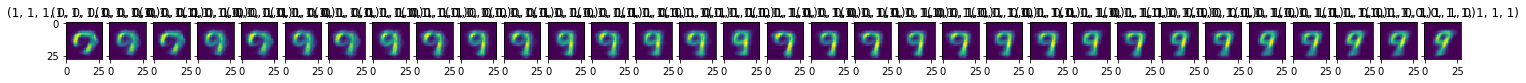

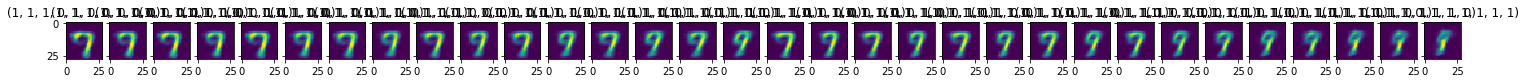

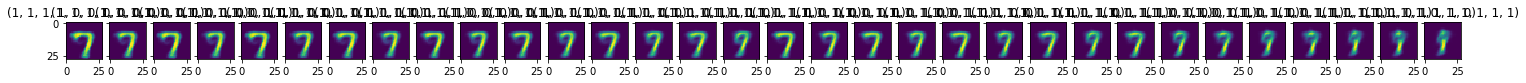

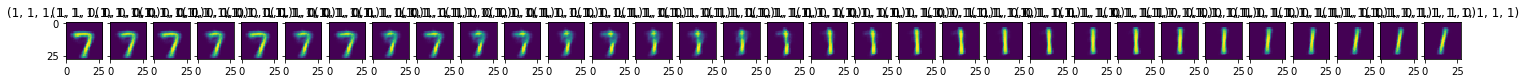

In [25]:
for i in range(32):
    debug(32*i)

In [15]:
#187.410 # remove /BSIZE, lr 1e-4, only use BCE+KLD